# Blackjack - prediction

In this notebook, we are interested in *learning* the value-function $v_\pi(s)$ and action-value function $q_\pi(s, a)$ for a given policy $\pi$

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numba import njit
from numba.core import types
from numba.typed import Dict

In [2]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(suppress=True)

* **Stick**: Player stops
* **Hit**: Request an additional card

In [3]:
# Value 10 corresponds to 10, Jack, Queen, and King.
n_vals = np.ones(10)
n_vals[-1] = 4
deck_probs = n_vals / n_vals.sum()

In [17]:
value = 21
value - PLAY_MINVAL

19

In [18]:
CARD_MIN = 1
CARD_MAX = 10

In [359]:
@njit
def set_seed(value):
    """
    See: https://github.com/numba/numba/issues/6002
    """
    np.random.seed(value)
    

@njit
def draw_card():
    return np.random.multinomial(1, deck_probs).argmax() + 1


@njit
def compute_reward(value_cards_player, value_cards_dealer):
    if value_cards_player == value_cards_dealer == 21:
        reward = 0 # draw
    elif value_cards_player > 21:
        reward = -1 # lose
    elif value_cards_dealer > 21:
        reward = 1 # win
    elif value_cards_player == value_cards_dealer:
        reward = 0 # draw
    elif value_cards_player > value_cards_dealer:
        reward = 1 # win
    else:
        reward = -1 # lose
    
    return reward


@njit
def init_game():
    value_cards_player = np.array([draw_card(), draw_card()])
    has_usable_ace = 1 in value_cards_player
    value_cards_player = value_cards_player.sum() + 10 * has_usable_ace
    
    dealers_card = draw_card() # Dealer's one-showing card
    
    return value_cards_player, has_usable_ace, dealers_card


@njit
def update_hand(value_cards):
    """
    Update the value of the hand for either the player
    or the dealer
    """
    new_card = draw_card()
    value_cards = value_cards + new_card
    
    if (new_card == 1) and (value_cards <= 10):
        has_usable_ace = True
        value_cards = value_cards + 10 # Make use of the ace
        
    return value_cards, has_usable_ace


@njit
def state_to_ix(value_cards_player, has_usable_ace, dealers_card):
    ix_value_cards = value_cards_player - PLAY_MINVAL
    ix_has_usable_ace = int(has_usable_ace)
    ix_dealers_card = dealers_card - CARD_MIN
    
    ixs = ix_value_cards, ix_has_usable_ace, ix_dealers_card
    return ixs


@njit
def step_player(
    value_cards_player,
    has_usable_ace,
    dealers_card,
    policy
):
    continue_play = True
    # turn into indices
    ixs = state_to_ix(value_cards_player, has_usable_ace, dealers_card)
    ix_value_cards, ix_has_usable_ace, ix_dealers_card = ixs
    action = policy[ix_value_cards, ix_has_usable_ace, ix_dealers_card]
    
    if action == 1:
        value_cards_player, has_usable_ace_new = update_hand(value_cards_player)
        has_usable_ace = has_usable_ace or has_usable_ace_new
        
    if (value_cards_player >= 21) or (action == 0):
        continue_play = False
    
    return value_cards_player, has_usable_ace, action, continue_play


@njit
def dealer_strategy(dealers_card):
    """
    The dealer hits or sticks according to a fixed strategy:
    Stick on any sum of 17 or greater and hit otherwise
    """
    value_cards_dealer = dealers_card + 10 * (dealers_card == 1)
    while value_cards_dealer < 17:
        value_cards_dealer, _ = update_hand(value_cards_dealer)
        
    return value_cards_dealer

    
@njit
def play_single(value_cards_player, has_usable_ace, dealers_card, policy):
    reward = 0
    
    continue_play = True
    while continue_play:
        value_cards_player, has_usable_ace, action, continue_play = step_player(
            value_cards_player, has_usable_ace, dealers_card, policy
        )
    
    value_cards_dealer = dealer_strategy(dealers_card)
    
    reward = compute_reward(value_cards_player, value_cards_dealer)
    return reward, (value_cards_player, value_cards_dealer)


@njit
def play_single_hist(value_cards_player, has_usable_ace, dealers_card, policy):
    """
    Play game and store intermediate steps
    """
    reward = 0
    
    states = [[value_cards_player, has_usable_ace, dealers_card]]
    rewards = []
    actions = []
    
    continue_play = True
    while continue_play:
        value_cards_player, has_usable_ace, action, continue_play = step_player(
            value_cards_player, has_usable_ace, dealers_card, policy
        )
        
        rewards.append(0)
        actions.append(action)
        states.append([value_cards_player, has_usable_ace, dealers_card])
    
    value_cards_dealer = dealer_strategy(dealers_card)
    
    reward = compute_reward(value_cards_player, value_cards_dealer)
    rewards.append(reward)
    
    hist = (
        states,
        actions,
        rewards
    )
    
    return reward, (value_cards_player, value_cards_dealer), hist

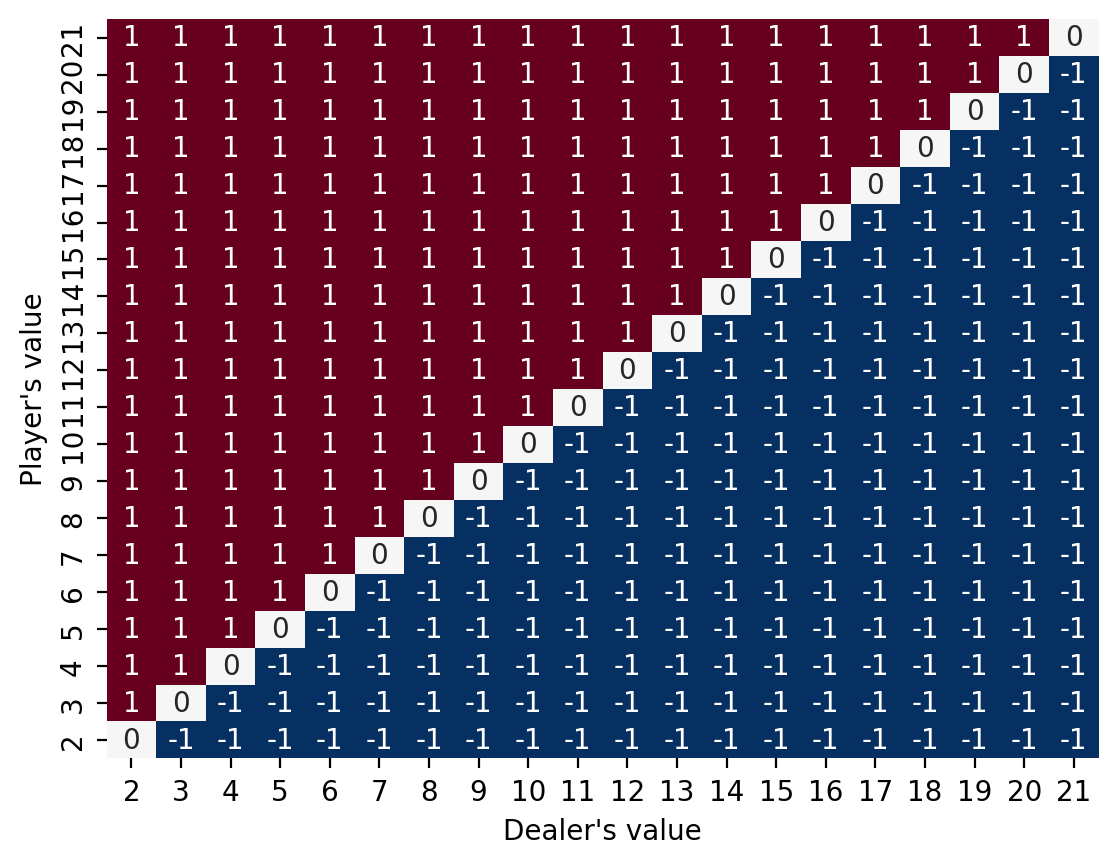

In [716]:
value_cards = np.arange(2, 22)

rewards_grid = np.array([[compute_reward(p, d) for d in value_cards] for p in value_cards])
rewards_grid = pd.DataFrame(rewards_grid, index=value_cards, columns=value_cards)
ax = sns.heatmap(rewards_grid, cmap="RdBu_r", annot=True, cbar=False)
ax.invert_yaxis()
plt.ylabel("Player's value")
plt.xlabel("Dealer's value");

The player makes a decision on the basis of three variables:
1. his current sum (12-21),
2. the dealer's one showing card (ace-10), and
3. whether or not he holds a usable ace

In [361]:
# Number of states
(21 - 12 + 1) * (10 - 1 + 1) * 2

200

In [667]:
PLAY_MINVAL = 2
PLAY_MAXVAL = 21

# We consider the policy that sticks if the player's sum is 20 or 21
# and sticks otherwise
policy = np.zeros((
    PLAY_MAXVAL - PLAY_MINVAL + 1, # Player's value
    2, # has usable ace
    10 # Dealer's one showing card
), dtype=np.int32)
policy[:-2] = 1

policy.shape

(20, 2, 10)

In [668]:
state_init = (20, 1, 10)
play_single(*state_init, policy=policy)

(0, (20, 20))

In [669]:
state_init = init_game()
state_init

(12, False, 8)

### Analysing play-by-play

In [670]:
set_seed(31415)
state_init = (4, 0, 5)
reward, values, hist = play_single_hist(*state_init, policy=policy)

In [671]:
# states
hist[0][:-1]

[[4, 0, 5], [7, 0, 5], [15, 0, 5]]

In [672]:
# actions
hist[1]

[1, 1, 1]

In [673]:
# rewards
hist[2][1:]

[0, 0, -1]

$$
    S_0, A_0, R_1, S_1, A_1, R_2, \ldots, S_{T-1}, A_{T-1}, R_T
$$

## Estimating the value function via first-visit MC

In [727]:
set_seed(31415)
discount = 1
state_init = init_game()
reward, values, hist = play_single_hist(*state_init, policy=policy)

hist_state, hist_action, hist_reward = hist

hist_state

[[11, 0, 10], [12, 1, 10], [15, 1, 10], [25, 1, 10]]

In [678]:
grid_rewards = np.zeros_like(policy)
grid_count = np.zeros_like(policy)

In [679]:
@njit
def single_first_visit_mc(grid_rewards, grid_count, policy):
    grid_rewards = grid_rewards.copy()
    grid_count = grid_count.copy()
    
    player_cards, ace, dealer_card = init_game()
    reward, values, hist = play_single_hist(player_cards, ace, dealer_card, policy=policy)
    hist_state, hist_action, hist_reward = hist
    T = len(hist_state)

    elements = []
    sim_reward = 0
    for t in range(-2, -(T + 1), -1):
        r = hist_reward[t + 1]
        sim_reward = discount * sim_reward + r

        current_state = hist_state[t]
        previous_states = hist_state[:t]

        first_visit = current_state not in previous_states
        if first_visit:    
            value_cards_player, has_usable_ace, dealers_card = current_state
            ixs = state_to_ix(value_cards_player, has_usable_ace, dealers_card)
            ix_value_cards, ix_has_usable_ace, ix_dealers_card = ixs

            grid_rewards[ix_value_cards, ix_has_usable_ace, ix_dealers_card] = sim_reward
            grid_count[ix_value_cards, ix_has_usable_ace, ix_dealers_card] = 1
            
            element = (ixs, sim_reward)
            elements.append(element)
    
    return elements

In [680]:
single_first_visit_mc(grid_rewards, grid_count, policy)

[((17, 1, 5), -1), ((11, 0, 5), -1)]

In [682]:
@njit(parallel=True)
def first_visit_mc(policy, n_sims):
    grid_rewards = np.zeros_like(policy)
    grid_count = np.zeros_like(policy)
    
    for s in prange(n_sims):
        hits = single_first_visit_mc(grid_rewards, grid_count, policy)
        for element in hits:
            ixs, sim_reward = element
            ix_value_cards, ix_has_usable_ace, ix_dealers_card = ixs
            
            grid_rewards[ix_value_cards, ix_has_usable_ace, ix_dealers_card] += sim_reward
            grid_count[ix_value_cards, ix_has_usable_ace, ix_dealers_card] += 1

    
    return grid_rewards, grid_count

In [707]:
grid_rewards, grid_count = first_visit_mc(policy, 1_000_000)

grid_value_function = grid_rewards / np.clip(grid_count, 1, None)

vf_no_ace = grid_value_function[:, 0, :]
vf_no_ace = pd.DataFrame(vf_no_ace, index=np.arange(PLAY_MINVAL, PLAY_MAXVAL + 1), columns=np.arange(1, 11))

vf_ace = grid_value_function[:, 1, :]
vf_ace = pd.DataFrame(vf_ace, index=np.arange(PLAY_MINVAL, PLAY_MAXVAL + 1), columns=np.arange(1, 11))

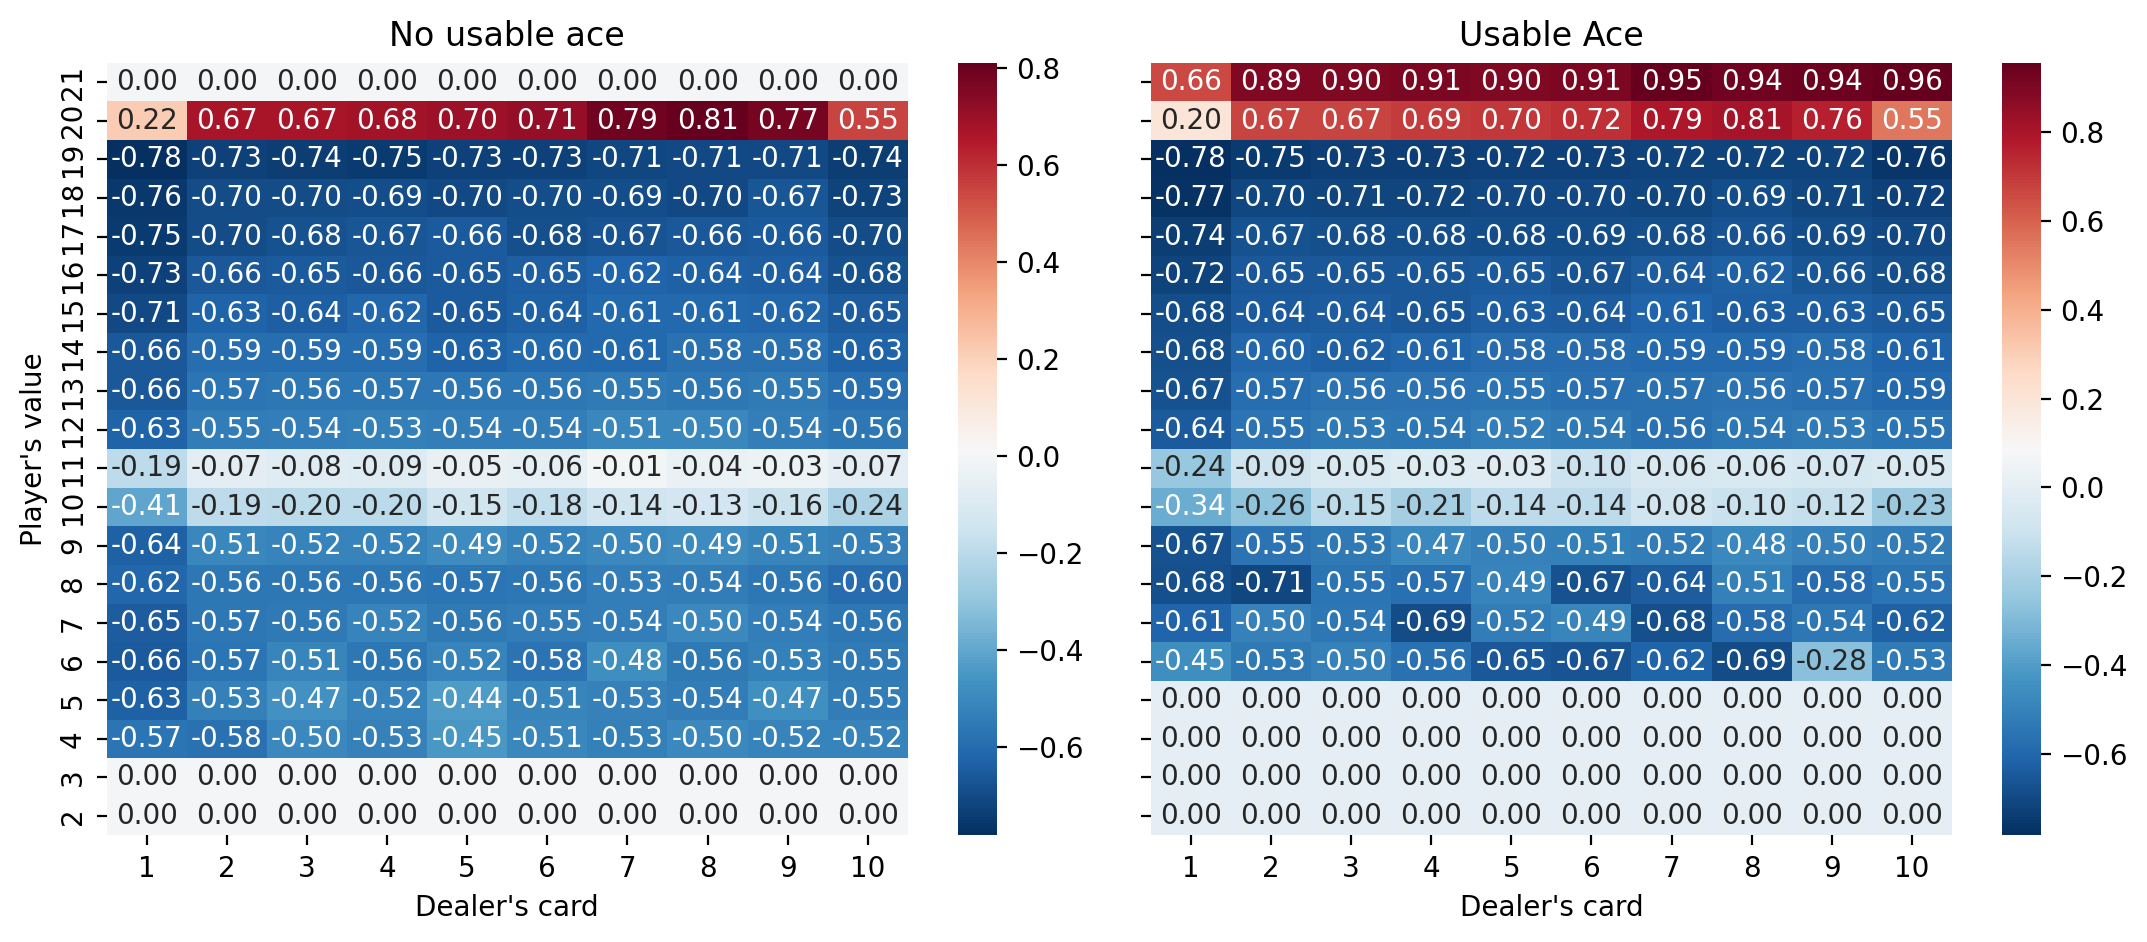

In [708]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4.8), sharey=True)
for axi, vf in zip(ax, [vf_no_ace, vf_ace]):
    sns.heatmap(vf, cmap="RdBu_r", ax=axi, annot=True, fmt="0.2f")
    axi.set_xlabel("Dealer's card")

ax[0].set_ylabel("Player's value")
ax[0].set_title("No usable ace")
ax[1].set_title("Usable Ace")
ax[0].invert_yaxis()
plt.tight_layout()